##  Contents:

### 0. Load packages and data

In [383]:
%matplotlib inline

# import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
# from sklearn.grid_search import GridSearchCV   
# from sklearn.model_selection import train_test_split, PredefinedSplit
# from sklearn.metrics import make_scorer, accuracy_score
# from sklearn.preprocessing import StandardScaler


In [62]:
# Load the data (with features)
data = pd.read_csv("../feature_engineering/features.csv")

A quick peak to see everything loaded fine

In [355]:
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,num_words_q1,...,cosine_distance_sentence_embeddings,cityblock_distance_sentence_embeddings,jaccard_distance_sentence_embeddings,braycurtis_distance_sentence_embeddings,q1_highest_tfidf_weight,q2_highest_tfidf_weight,q1_max_tf_idf_embedding,q2_max_tf_idf_embedding,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word
0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,14,...,0.004921,3.938651,1.0,0.049871,guide,guide,[-0.028461 -0.34314999 0.23021001 -0.063865...,[-0.028461 -0.34314999 0.23021001 -0.063865...,0.000000,3.250036e-08
1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,10,...,0.027946,10.689272,1.0,0.129334,noor,noor,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,0.000000,4.103800e-08
2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,14,...,0.010569,5.988954,1.0,0.075329,vpn,dns,[-0.14387 0.66254002 -0.23895 0.036253...,[ -4.19200003e-01 5.06489992e-01 -3.4162998...,5.495713,4.284846e-01
3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,11,...,0.065936,15.007527,1.0,0.184240,mentally,remainder,[ -1.92690000e-01 -3.28700006e-01 -4.2276001...,[-0.39732999 -0.13798 0.21100999 0.237990...,4.781672,8.190252e-01
4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,13,...,0.038453,11.145288,1.0,0.142762,di,salt,[ -1.13650002e-01 -3.47779989e-02 8.1817999...,[-0.064408 -0.073121 -0.25946999 0.15424 ...,6.219034,8.441631e-01


#### 0.1 A look at the extracted features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1134f6fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127c2bfd0>]], dtype=object)

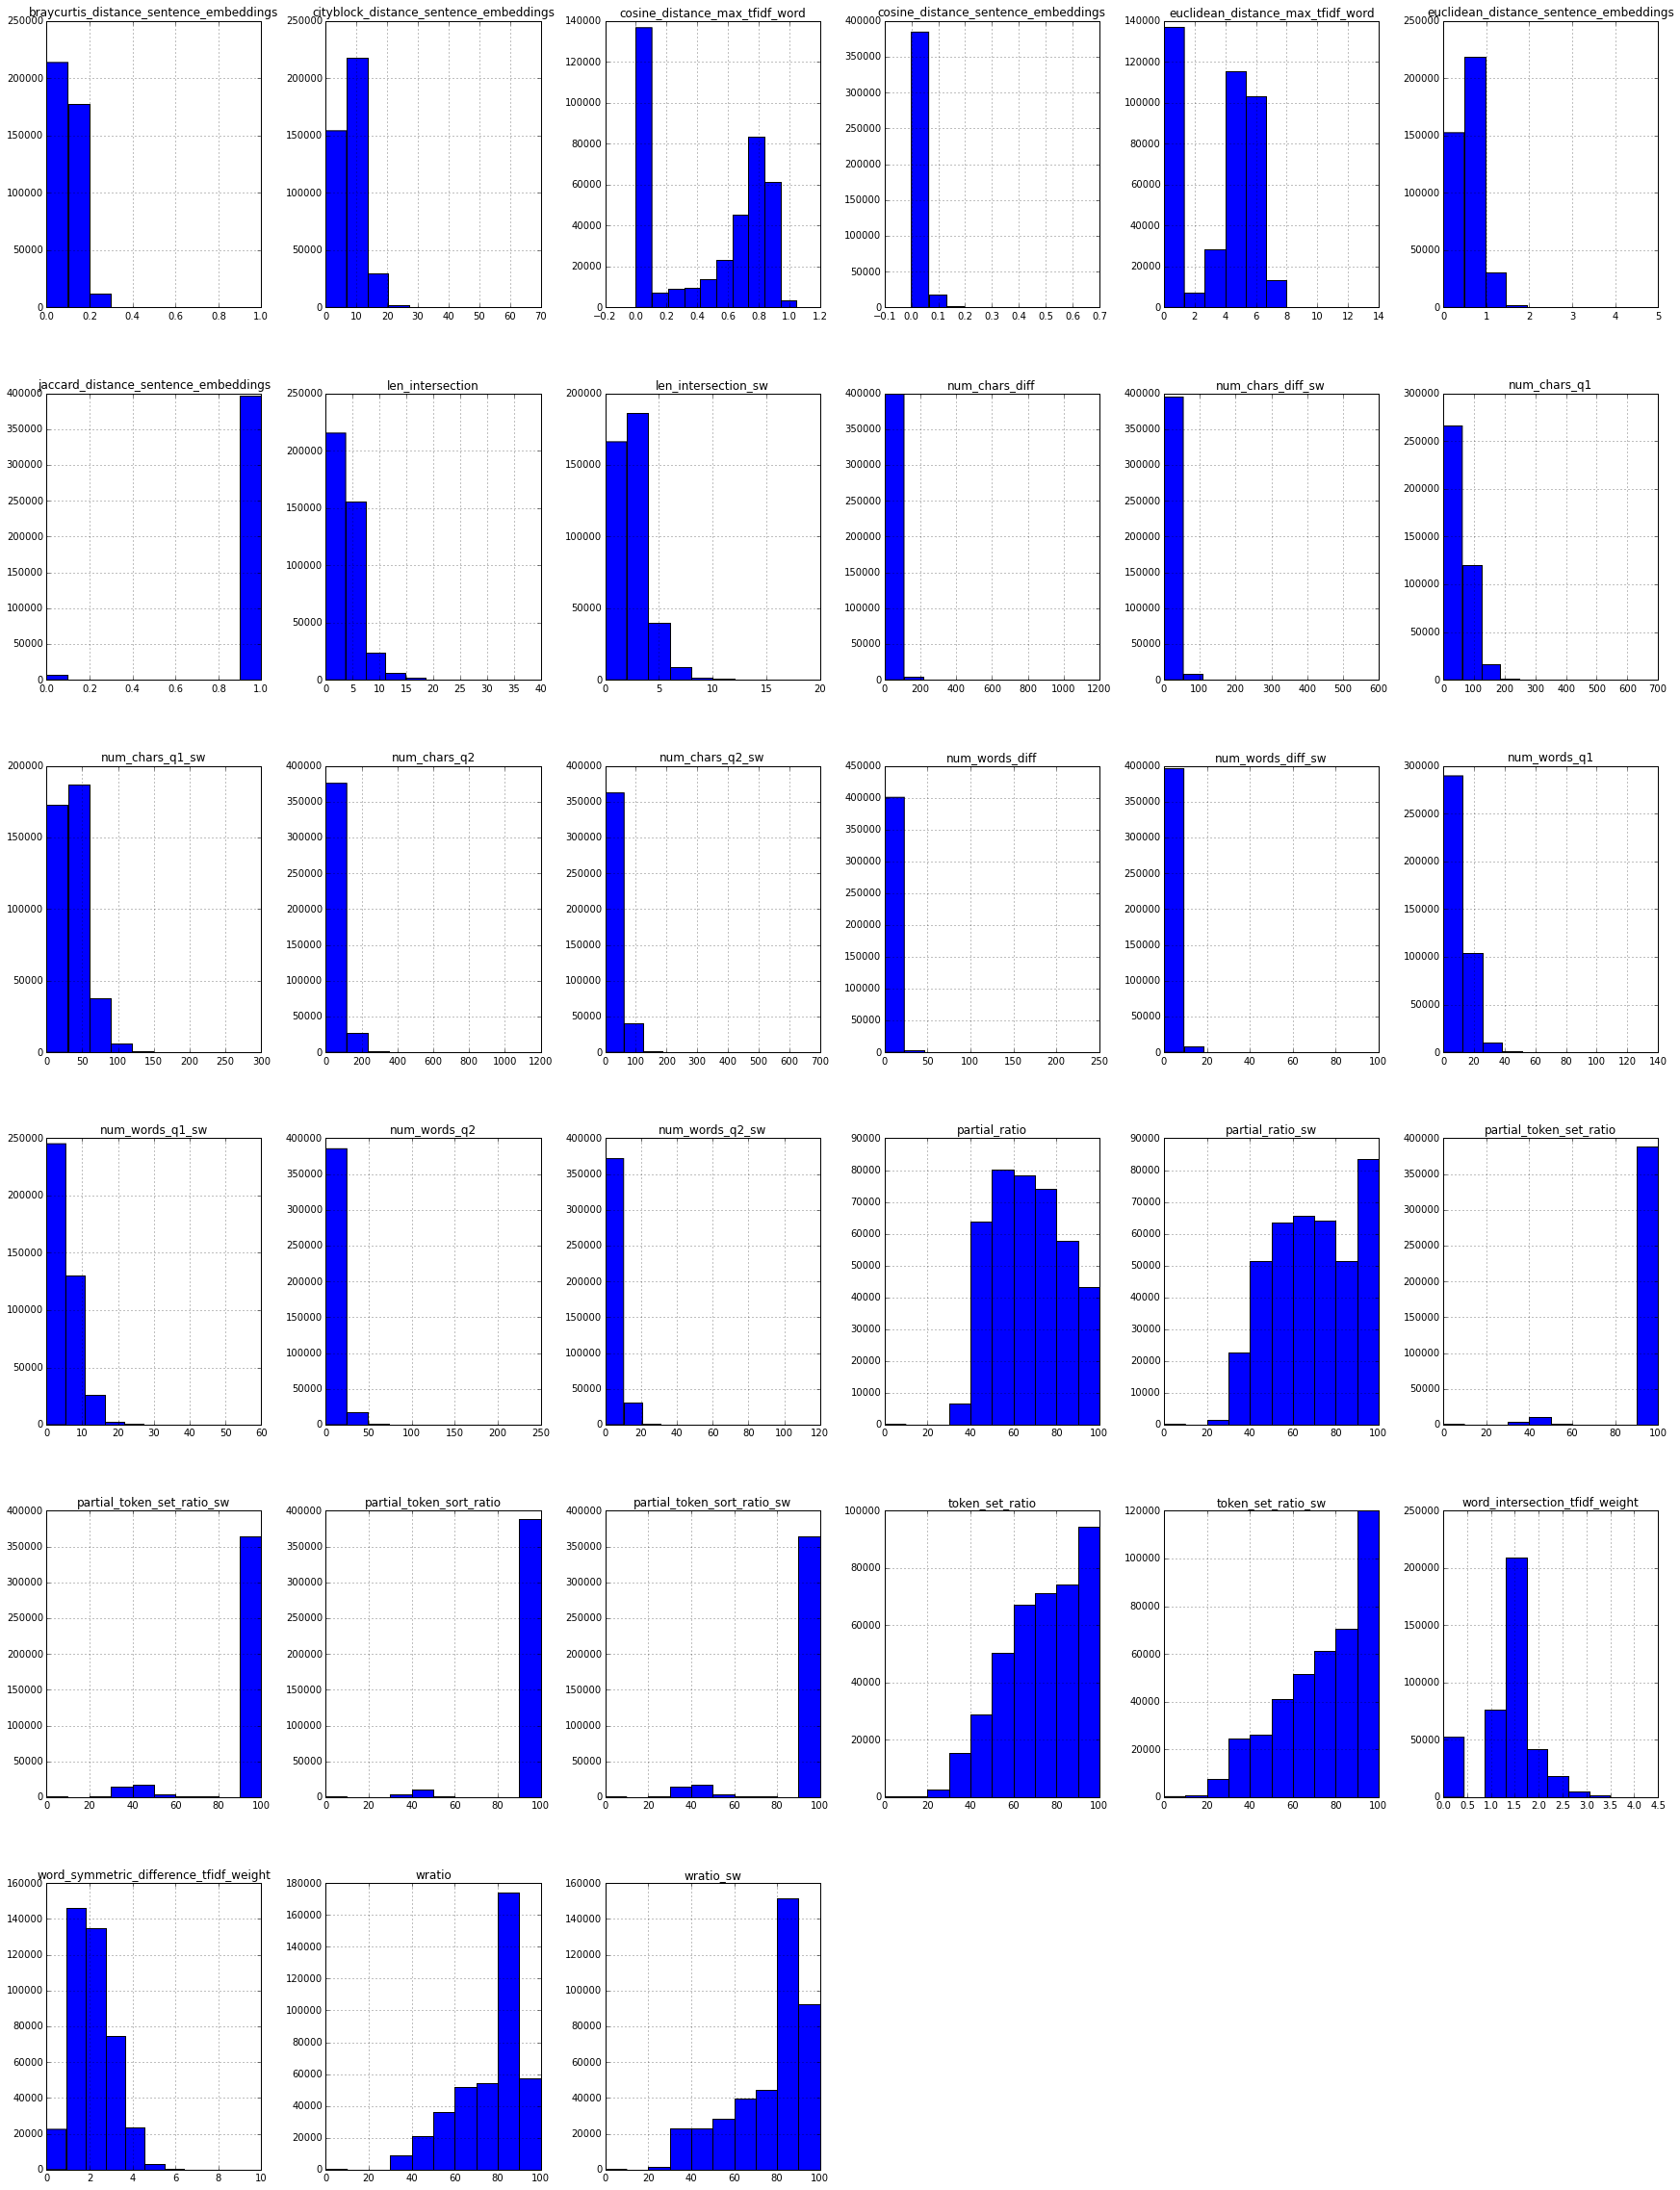

In [11]:
plt.figure()
data[[ u'len_intersection', u'len_intersection_sw',
       u'num_words_q1', u'num_words_q1_sw', u'num_words_q2',
       u'num_words_q2_sw', u'num_words_diff', u'num_words_diff_sw',
       u'num_chars_q1', u'num_chars_q1_sw', u'num_chars_q2',
       u'num_chars_q2_sw', u'num_chars_diff', u'num_chars_diff_sw',
       u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio',
       u'partial_token_set_ratio_sw', u'token_set_ratio',
       u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight', 
       u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_distance_sentence_embeddings', 
       u'euclidean_distance_max_tfidf_word',
       u'cosine_distance_max_tfidf_word']].hist(figsize=(30, 40))

### 1.0 Setting up testing environment

#### 1.1 Keeping features that would like to experiment with.

Some of these features don't make sense in the context of boosted trees (e.g word embeddings), or are intuitively meaningless (e.g partial token set ratio with stopwords). There are also pairs of features which don't make to keep (e.g num characters in q1, and number of characters in q1 excluding stopwords). 

Further, there are pairs of features that would clearly be redundunt if included. For example, partial token sort ratio and paritial token sort ratio without stopwords do not both need to be incldued. 

Boosted trees, like other ensemble tree-based methods, is relatively robust with regard to correlated features. Thus, it's not of huge concern to include features that are likely correlated. The only reason why I exclude some features it to speed up training, and hopefully keep the the feature importance weights (f scores) 

In [14]:
data.columns

Index([u'Unnamed: 0', u'id', u'qid1', u'qid2', u'question1', u'question2',
       u'is_duplicate', u'len_intersection', u'len_intersection_sw',
       u'num_words_q1', u'num_words_q1_sw', u'num_words_q2',
       u'num_words_q2_sw', u'num_words_diff', u'num_words_diff_sw',
       u'num_chars_q1', u'num_chars_q1_sw', u'num_chars_q2',
       u'num_chars_q2_sw', u'num_chars_diff', u'num_chars_diff_sw',
       u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio',
       u'partial_token_set_ratio_sw', u'token_set_ratio',
       u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight', u'q1_embedding',
       u'q2_embedding', u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_di

In [21]:
# variables on which we will train
training_features = [u'len_intersection', u'len_intersection_sw', u'num_words_q1', u'num_words_q2',
                     u'num_words_diff', u'num_words_diff_sw', u'num_chars_q1', u'num_chars_q2', 
                     u'num_chars_diff', u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio_sw',
                     u'token_set_ratio', u'token_set_ratio_sw', u'partial_token_sort_ratio_sw', 
                     u'wratio', u'wratio_sw', u'word_intersection_tfidf_weight', 
                     u'word_symmetric_difference_tfidf_weight', u'euclidean_distance_sentence_embeddings',
                     u'cosine_distance_sentence_embeddings', u'cityblock_distance_sentence_embeddings', 
                     u'jaccard_distance_sentence_embeddings', u'braycurtis_distance_sentence_embeddings', 
                     u'euclidean_distance_max_tfidf_word', u'cosine_distance_max_tfidf_word']
# response variable
training_response = ['is_duplicate']

#### 1.2  Splitting data in to training and test set. 

For this experiment, I will split the _training_ set provided by Kaggle (`train.csv`) into a training set and test set. This is because I would like to introduce linguistic features down the line, and since most of the quesitons in `test.csv` are computer generated and ungrammatical (see Kaggle discussions), I linguistic features which analyze the syntax and grammar of a sentence might not work on the data in `test.csv`, and so it will be hard to guage their effectiveness.

For reproducability, I am using the seed **550** throughout. 


In [ ]:
# quick fix - fixed on the features notebook but did not re-save data yet

fill = data[pd.isnull(data['cosine_distance_max_tfidf_word'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_max_tf_idf_embedding'], x['q2_max_tf_idf_embedding'])  
                        else 1, axis = 1)

data['cosine_distance_max_tfidf_word'] = data['cosine_distance_max_tfidf_word'].fillna(fill)

In [ ]:
fill = data[pd.isnull(data['cosine_distance_sentence_embeddings'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_embedding'], x['q2_embedding'])  
                        else 1, axis = 1)

if len(fill) > 0:
    data['cosine_distance_sentence_embeddings'] = data['cosine_distance_sentence_embeddings'].fillna(fill)

In [356]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    data[training_features], data[training_response], test_size=0.2, random_state=550)

In [357]:
# sanity check - dimensions of training and test splits
print(X_train.shape)
print(X_test.shape)
print
print(y_train.shape)
print(y_test.shape)

(323430, 26)
(80858, 26)

(323430, 1)
(80858, 1)


Finally, creating a sample for experimentation:

In [365]:
data_sample = data.sample(500, random_state=550)

In [366]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    data_sample[training_features], data_sample[training_response], test_size = .2, random_state = 550) 

In [367]:
print(X_train_sample.shape)
print(X_test_sample.shape)
print
print(y_train_sample.shape)
print(y_test_sample.shape)

(400, 26)
(100, 26)

(400, 1)
(100, 1)


`GridSearchCV` objects cause problems if the responses are not column vectors (as apposed to single column matrices). Converting them as such:

In [368]:
y_train = y_train.values.reshape(y_train.shape[0])
y_test = y_test.values.reshape(y_test.shape[0])
y_train_sample = y_train_sample.values.reshape(y_train_sample.shape[0])

#### 1.3 Developement and cross validation set

I usually use a k-fold cross validation scheme, but for my initial experiments (where error can change drastically until I get the hyperparameters into the right ballpark), I don't need the precision of k-fold cross validation. 

Thus, it is useful to have a regular developement set as well. 

In [376]:
# indecies for validation set
validation_idx = np.repeat(-1, y_train.shape)
np.random.seed(550)
validation_idx[np.random.choice(validation_idx.shape[0], int(round(.2*validation_idx.shape[0])), replace = False)] = 0

In [415]:
# create a validation set split.
# This will contain a list with two elements - one being the list of training indecies and the next a list of 
# validation idecies. 
validation_split = list(PredefinedSplit(validation_idx).split())

In [421]:
# sanity check
print(abs(validation_idx.sum()))
print(abs(validation_idx.sum())/float(validation_idx.shape[0]))
print(validation_idx.shape[0] == y_train.shape[0])
print(set(validation_split[0][0]).intersection(set(validation_split[0][1])))

258744
0.8
True
set([])


#### 1.TODO Zero mean standardizing

In this stage I would typically standardize my design matrix. But I have not found concensus that this is the right thing to do when using ensemble trees. 

Thus, I will initialize a `StandardScalar`, and fit a model with/without standardizing, and see if it has an affect on cross validation error. 

In [81]:
# fit a StandardScalar
scalar = StandardScaler().fit(X_train)

### 2. Functions for running and diagnosting XGboost models

#### 2.0 A function which returns the variable importance given a model

In [192]:
def feature_importance(model):
    pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False).plot(kind = "bar")

### 3. Approximate the number and depth of the estimators

There are a bunch of parameters to tune when using `XGboost`, but the one which affects the time it takes to train are the number of estimators (trees) and the depth of each tree. 

Further, these parameters tend to yield a point of diminishing return rather quicly. Thus, I'll get a rough approximation as to the optimal number of trees and the depth of trees using a `GridSearchCV`, and then move on to more fine parameter tuning once I have a better idea of the scale of the size of my ensemble


In [315]:
# a vanilla XGboost model
model1 = XGBClassifier()

In [314]:
# create a parameter grid for the number of trees and depth of trees
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [287]:
# Create gridsearch cross validation object

grid_search = GridSearchCV(model1, param_grid, scoring='neg_log_loss', n_jobs=-1, cv=6, verbose=1)

In [316]:
%time grid_result = grid_search.fit(X_train, y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 79.1min finished


CPU times: user 4min 31s, sys: 2.58 s, total: 4min 33s
Wall time: 1h 23min 17s


In [317]:
grid_result.grid_scores_

[mean: -0.51317, std: 0.00141, params: {'n_estimators': 50, 'max_depth': 2},
 mean: -0.49886, std: 0.00147, params: {'n_estimators': 100, 'max_depth': 2},
 mean: -0.49171, std: 0.00144, params: {'n_estimators': 150, 'max_depth': 2},
 mean: -0.48705, std: 0.00142, params: {'n_estimators': 200, 'max_depth': 2},
 mean: -0.49153, std: 0.00135, params: {'n_estimators': 50, 'max_depth': 4},
 mean: -0.47375, std: 0.00181, params: {'n_estimators': 100, 'max_depth': 4},
 mean: -0.46556, std: 0.00177, params: {'n_estimators': 150, 'max_depth': 4},
 mean: -0.46050, std: 0.00183, params: {'n_estimators': 200, 'max_depth': 4},
 mean: -0.47367, std: 0.00155, params: {'n_estimators': 50, 'max_depth': 6},
 mean: -0.45774, std: 0.00186, params: {'n_estimators': 100, 'max_depth': 6},
 mean: -0.45110, std: 0.00195, params: {'n_estimators': 150, 'max_depth': 6},
 mean: -0.44709, std: 0.00200, params: {'n_estimators': 200, 'max_depth': 6},
 mean: -0.46052, std: 0.00155, params: {'n_estimators': 50, 'max_de

In [320]:
grid_result.best_params_

{'max_depth': 8, 'n_estimators': 200}

In [321]:
grid_result.best_score_

-0.43843931879187314

We can see that the algorithm performs best with many deep trees. THe fact that the log loss reduces subtancially from 200 trees to 150 trees with a depth of 8 makes me think that I unerestimated the number of estimators needed. A more appropriate range should be [200, 400, ... 1000]. 

A quick look at the feature importance:

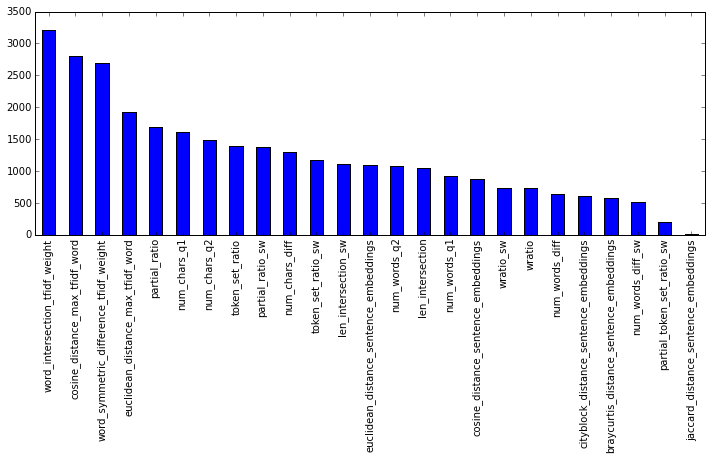

In [322]:
feature_importance(grid_result.best_estimator_)

I'll try this again, but this time up the number of estimators. 

In [422]:
# create a parameter grid for the number of trees and depth of trees
n_estimators2 = range(300, 1100, 100)
max_depth2 = [8, 10]
param_grid2 = dict(max_depth=max_depth2, n_estimators=n_estimators2)

In [423]:
# a second gridsearch
grid_search2 = GridSearchCV(model1, param_grid2, scoring='neg_log_loss', n_jobs=-1, cv=validation_split, verbose=1)

In [424]:
%time grid_result2 = grid_search2.fit(X_train, y_train)

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 133.5min finished


CPU times: user 21min 9s, sys: 7.45 s, total: 21min 16s
Wall time: 2h 34min 53s


In [426]:
grid_result2.grid_scores_

[mean: -0.43508, std: 0.00000, params: {'n_estimators': 300, 'max_depth': 8},
 mean: -0.43211, std: 0.00000, params: {'n_estimators': 400, 'max_depth': 8},
 mean: -0.43021, std: 0.00000, params: {'n_estimators': 500, 'max_depth': 8},
 mean: -0.42849, std: 0.00000, params: {'n_estimators': 600, 'max_depth': 8},
 mean: -0.42698, std: 0.00000, params: {'n_estimators': 700, 'max_depth': 8},
 mean: -0.42543, std: 0.00000, params: {'n_estimators': 800, 'max_depth': 8},
 mean: -0.42493, std: 0.00000, params: {'n_estimators': 900, 'max_depth': 8},
 mean: -0.42425, std: 0.00000, params: {'n_estimators': 1000, 'max_depth': 8},
 mean: -0.43068, std: 0.00000, params: {'n_estimators': 300, 'max_depth': 10},
 mean: -0.42796, std: 0.00000, params: {'n_estimators': 400, 'max_depth': 10},
 mean: -0.42641, std: 0.00000, params: {'n_estimators': 500, 'max_depth': 10},
 mean: -0.42540, std: 0.00000, params: {'n_estimators': 600, 'max_depth': 10},
 mean: -0.42502, std: 0.00000, params: {'n_estimators': 700

In [427]:
grid_result2.best_params_

{'max_depth': 8, 'n_estimators': 1000}

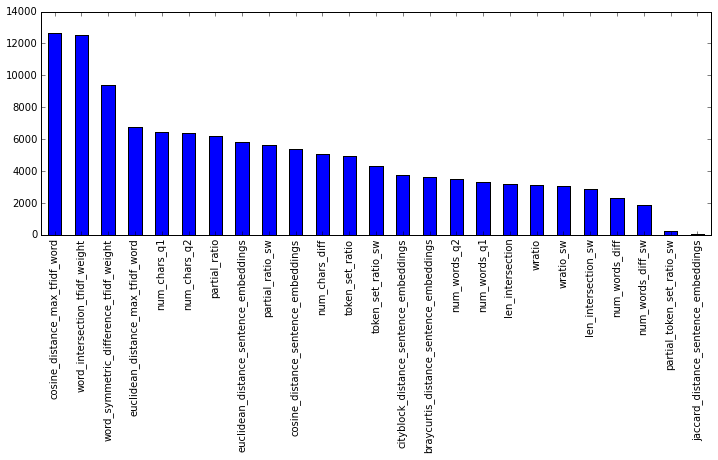

In [425]:
feature_importance(grid_result2.best_estimator_)

In [ ]:
A quick peak at the cross validation accuracy score

In [449]:
accuracy_score(y_pred = grid_result2.predict(X_train.iloc[validation_split[0][1]]),
               y_true=y_train[validation_split[0][1]])

0.89207865689639176

In [435]:
X_train[validation_split[0][1].tolist(),]

TypeError: unhashable type: 'list'

In [431]:
grid_result2.predict(X_train[validation_split[0][1]])

IndexError: indices are out-of-bounds